## Budget in MITgcm. Part IV: energy budget
**25 January 2020 by MiniUFO and Wendy**

---
[TOC]

---
### 1. Introduction
As Part IV of a series of notebook here we will do kinetic energy budget using the model of [MITgcm](http://mitgcm.org/), and its related [python](https://www.python.org/) analysis package like [xmitgcm](https://github.com/xgcm/xmitgcm) and [xgcm](https://github.com/xgcm/xgcm).  Although it is very convenient under the help of these packages, it will shown that the energy budget is complicated due to the difference schemes and [Arakawa C grid](https://mitgcm.readthedocs.io/en/latest/algorithm/c-grid.html) adopted in MITgcm.

---

### 2. Theoretical guide
###### 2.1 General equation for the momentum
The oceanic fluid simulated by MITgcm is driven by wind stress and buoyancy forcings.  These forcings exsert their effects at the surface and their energy input is eventually dissipated by visous or radiative processes.

The kinetic energy $E_k=(\mathbf u \cdot \mathbf u)/2$ equation, under hydrostatic and nondivergent assumptions, are given as ([Kang's dissertation](https://stacks.stanford.edu/file/druid:sv691gk5449/kdj_thesis-augmented.pdf)):
>$$\frac{\partial E_k}{\partial t}=-\nabla\cdot(\mathbf u E_k)-\frac{\rho'}{\rho_0}gw+PG+DIFF+DISS+\mathbf u\cdot \mathbf F \tag{1}$$

where the terms on the rhs are the advection term, conversion (to potential energy) term, pressure gradient term (PG), diffusion term, dissipation term and energy source/sink due to external force $F$ (e.g., wind stress and bottom/side drags), respectively.  The diffusion and dissipation terms reads:
>$$DIFF=\nabla_H\cdot(\mu_H\nabla_H E_k)+\frac{\partial}{\partial z}(\mu_V \frac{\partial E_k}{\partial z})\tag{2}$$

>$$DISS=-\mu_H\nabla_H\mathbf u\cdot\nabla_H\mathbf u-\mu_V\frac{\partial \mathbf u}{\partial z}\cdot\frac{\partial \mathbf u}{\partial z}\tag{3}$$

###### 2.2 Pressure gradient terms
In MITgcm, the pressure gradient term is splitted into [three parts](https://mitgcm.readthedocs.io/en/latest/overview/hydrostatic.html): the surface, hydrostatic and nonhydrostatic terms:
>$$PG=-\mathbf u_H\nabla_H (g\eta)-\frac{1}{\rho_0}\nabla\cdot (\mathbf u p_{hyd})-\frac{1}{\rho_0}\nabla\cdot (\mathbf up_{nh}) \tag{4}$$

Notice that if your forcing includes Atmospheric pressure loading (```=atmP_load```), this contribution (```=-gradient```) needs to be added:

**```-1/rhoConst * (atmP_load(i) - atmP_load(i-1)) / DXC```**

and the same thing applies to seaice-loading:

**```-gravity/rhoConst * (sIceLoad(i) - sIceLoad(i-1)) / DXC```**

The fixed density to use is "```rhoConst```" and not "```rhoConstFresh```"

###### 2.3 Advection terms
Notice that the kinetic energy $E_k$ is defined at the [tracer point](https://xgcm.readthedocs.io/en/latest/example_mitgcm.html#Kinetic-Energy), which need a interpolation of momentum components from velocity points to tracer point.  Then one need to interpolate the $E_k$ to the velocity points for divergent calculation.

###### 2.4 Diffusion and dissipation terms
Note that the diffusion and dissipation terms are in a form slightly different from those as shown in [Osborn (1980, see his Eq. (5-6))](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0485%281980%29010%3C0083%3AEOTLRO%3E2.0.CO%3B2).  Here we use the form in ([Kang's dissertation](https://stacks.stanford.edu/file/druid:sv691gk5449/kdj_thesis-augmented.pdf)).  It is not clear which form is better for Arakawa c-grid discretizing.

###### 2.5 External forcings
External forcing includes the surface wind stress and lateral or bottom frictions.  Not testing yet.

---

### 3. Practice using xgcm/xmitgcm
According to the above, the kinetic energy tendency (KEtdc) budget equation is:
**total_KEtdc = advct_KEtdc + convs_KEtdc + press_KEtdc + diffu_KEtdc + dissi_KEtdc**

The MITgcm output diagnostics required for the heat budget are:

| Names in Equation |  Outpus required by MITgcm  | Description |
| ------------: | --------------------------- | ------------------- |
|  total_KEtdc | ```UVEL```, ```VVEL```, ```WVEL``` | total tendency of kinetic energy |
|  advct_KEtdc | ```UVEL```, ```VVEL```, ```WVEL``` | tendency due to 3D advection |
|   conv_KEtdc | ```WVEL```, ```RHOAnoma``` | tendency due to conversion to potential energy |
|  press_KEtdc | ```UVEL```, ```VVEL```, ```WVEL```, ```ETAN```, ```PHIHYD``` | tendency due to pressure gradient work |
|   diff_KEtdc | ```UVEL```, ```VVEL```, ```WVEL``` | tendency due to energy diffusion |
|   dssp_KEtdc | ```UVEL```, ```VVEL```, ```WVEL``` | tendency due to viscous dissipation |

One can find these names in available_diagnosis.log generated in the run directory and set them in data.diagnostics for output.  Then we start the budget analysis using [python](https://www.python.org/) and related packages.

First, we define a budget class in Python code as:


In [ ]:
'''
Created on 2019.12.31

@author: MiniUFO, Wendy
Copyright 2018. All rights reserved. Use is subject to license terms.
'''
import xmitgcm
import xgcm
import xarray as xr


class EnergyBudget(object):
    '''
    This class is designed for the energy budget analysis in MITgcm.
    '''
    def __init__(self, dset, metrics=None):
        '''
        Construct a Budget instance using a Dataset
        
        Parameters
        ----------
        dset : xarray.Dataset
            a given Dataset containing MITgcm output diagnostics
        
        Return
        ----------
        terms : xarray.Dataset
            A Dataset containing all budget terms
        '''
        if metrics is None:
            metrics = {
                ('X',    ): ['dxC', 'dxG'], # X distances
                ('Y',    ): ['dyC', 'dyG'], # Y distances
                ('Z',    ): ['drF', 'drC'], # Z distances
                ('X', 'Y'): ['rA' , 'rAz', 'rAs', 'rAw'] # Areas
            }
        
        self.grid   = xgcm.Grid(dset, metrics=metrics)
        self.coords = dset.coords.to_dataset().reset_coords()
        self.dset   = dset.reset_coords(drop=True)
        self.volume = dset.drF * dset.hFacC * dset.rA
        self.terms  = None

    '''
    Calculate all the budget tendency terms.
    '''
    def cal_kinetic_energy(self, uvel, vvel, wvel):
        '''
        Calculate kinetic energy per unit volume (J m^-3).
        Ek = 0.5 * rho0 * u * u
           = Ehk0 + Ekp + Ehk0p
        where
        Ehk0 = 0.5 * rho0 * Uh * Uh
        Ekp  = 0.5 * rho0 * (uHp * uHp + w^2)
        Ehk0p= rho0 * (U * up + V * vp)
        
        Parameters
        ----------
        uvel : string
            A given string for u in dataset.
        vvel : string
            A given string for v in dataset.
        wvel : string
            A given string for w in dataset.
        '''
        # get MITgcm diagnostics and calculate momenta
        u = self.dset[uvel] * self.coords.hFacW
        v = self.dset[vvel] * self.coords.hFacS
        w = self.dset[wvel]

        # interpolate to get tracer-point energy
        KE = ((self.grid.interp(u, 'X')**2 +
               self.grid.interp(v, 'Y')**2 +
               self.grid.interp(w, 'Z')**2
             )/self.coords.hFacC * 0.5).rename('KE')
        
        if self.terms is not None:
            self.terms['KE'] = KE
        else:
            self.terms = xr.merge([KE])
    
    def cal_true_tendency(self, KE, deltaT):
        '''
        Calculate true tendency output by the model.
        
        Parameters
        ----------
        KE : string
            A given string for kinetic energy in self.terms.
        '''
        # get MITgcm diagnostics
        Tdc = self.terms[KE].diff('time')

        # calculate the true tendency (J day^-1)
        total_KEtdc = Tdc / deltaT * 86400.0

        if self.terms is not None:
            self.terms['total_KEtdc'] = total_KEtdc
        else:
            self.terms = xr.merge([total_KEtdc])
    
    def cal_advection_tendency(self, uvel, vvel, wvel):
        '''
        Calculate tendency due to advection.
        
        Parameters
        ----------
        uvel : string
            A given string for u in dataset.
        vvel : string
            A given string for v in dataset.
        wvel : string
            A given string for w in dataset.
        '''
        # get MITgcm diagnostics
        grid   = self.grid
        coords = self.coords
        
        u  = self.dset[uvel]
        v  = self.dset[vvel]
        w  = self.dset[wvel]
        KE = self.terms['KE']

        # interpolate to velocity points
        KE_u = grid.interp(KE, 'X', boundary='fill')
        KE_v = grid.interp(KE, 'Y', boundary='fill')
        KE_w = grid.interp(KE, 'Z', boundary='fill')

        # calculate the fluxes
        ADVx = u * KE_u * coords.dyG * coords.hFacW * coords.drF
        ADVy = v * KE_v * coords.dxG * coords.hFacS * coords.drF
        ADVr = w * KE_w * coords.rA

        # difference to get flux convergence, sign convention is opposite for verticl
        adv_x_tdc = -grid.diff(ADVx, 'X', boundary='fill').rename('adv_x_KEtdc')
        adv_y_tdc = -grid.diff(ADVy, 'Y', boundary='fill').rename('adv_y_KEtdc')
        adv_r_tdc =  grid.diff(ADVr, 'Z', boundary='fill').rename('adv_r_KEtdc')

        # change unit to K/day
        adv_x_tdc = adv_x_tdc * 86400.0 / self.volume
        adv_y_tdc = adv_y_tdc * 86400.0 / self.volume
        adv_r_tdc = adv_r_tdc * 86400.0 / self.volume

        # sum up to get the total tendency due to advection
        advct_tdc = (adv_x_tdc + adv_y_tdc + adv_r_tdc).rename('advct_KEtdc')

        if self.terms is not None:
            self.terms['adv_x_KEtdc'] = adv_x_tdc
            self.terms['adv_y_KEtdc'] = adv_y_tdc
            self.terms['adv_r_KEtdc'] = adv_r_tdc
            self.terms['advct_KEtdc'] = advct_tdc
        else:
            self.terms = xr.merge([adv_x_tdc, adv_y_tdc, adv_r_tdc, advct_tdc])

    def cal_eta_tendency(self, uvel, vvel, eta, g=9.81):
        '''
        Calculate pressure gradient tendency due to surface elevation.
        
        Parameters
        ----------
        uvel : string
            A given string for u in dataset.
        vvel : string
            A given string for v in dataset.
        eta : string
            A given string for eta in dataset.
        '''
        # get MITgcm diagnostics
        grid   = self.grid
        coords = self.coords
        
        u  = self.dset[uvel]
        v  = self.dset[vvel]
        e  = self.dset[eta ]
        
        # interpolate to velocity points
        e_u = grid.interp(e, 'X', boundary='fill')
        e_v = grid.interp(e, 'Y', boundary='fill')

        # calculate the fluxes
        ADVx = u * e_u * g * coords.dyG * coords.hFacW * coords.drF
        ADVy = v * e_v * g * coords.dxG * coords.hFacS * coords.drF

        # difference to get flux convergence, sign convention is opposite for verticl
        adv_etax_tdc = -grid.diff(ADVx, 'X', boundary='fill').rename('adv_etax_KEtdc')
        adv_etay_tdc = -grid.diff(ADVy, 'Y', boundary='fill').rename('adv_etay_KEtdc')

        # change unit to K/day
        adv_etax_tdc *= 86400.0 / self.volume
        adv_etay_tdc *= 86400.0 / self.volume
        
        # sum up to get the total tendency due to harmonic diffusion
        adv_eta_tdc = (adv_etax_tdc + adv_etay_tdc).rename('adv_eta_KEtdc')

        if self.terms is not None:
            self.terms['adv_etax_KEtdc'] = adv_etax_tdc
            self.terms['adv_etay_KEtdc'] = adv_etay_tdc
            self.terms['adv_eta_KEtdc' ] = adv_eta_tdc
        else:
            self.terms = xr.merge([adv_etax_tdc, adv_etay_tdc, adv_eta_tdc])
    
    def cal_pressure_tendency(self, uvel, vvel, wvel, phihyd, rhoRef=999.8):
        '''
        Calculate pressure gradient tendency.
        
        Parameters
        ----------
        uvel   : string
            A given string for u in dataset.
        vvel   : string
            A given string for v in dataset.
        wvel   : string
            A given string for w in dataset.
        phihyd : string
            A given string for hydrostatic pressure potential anomaly in dataset.
        rhoRef : float
            The reference density that phihyd = p / rhoRef.
        '''
        # get MITgcm diagnostics
        grid   = self.grid
        coords = self.coords
        
        u  = self.dset[uvel  ]
        v  = self.dset[vvel  ]
        w  = self.dset[wvel  ]
        p  = self.dset[phihyd] #* rhoRef
        
        # interpolate to velocity points
        p_u = grid.interp(p, 'X', boundary='fill')
        p_v = grid.interp(p, 'Y', boundary='fill')
        p_w = grid.interp(p, 'Z', boundary='fill')
        
        # calculate the fluxes
        ADVx = u * p_u * coords.dyG * coords.hFacW * coords.drF
        ADVy = v * p_v * coords.dxG * coords.hFacS * coords.drF
        ADVr = w * p_w * coords.rA
        
        # difference to get flux convergence, sign convention is opposite for verticl
        adv_px_tdc = -grid.diff(ADVx, 'X', boundary='fill').rename('adv_px_KEtdc')
        adv_py_tdc = -grid.diff(ADVy, 'Y', boundary='fill').rename('adv_py_KEtdc')
        adv_pr_tdc =  grid.diff(ADVr, 'Z', boundary='fill').rename('adv_pr_KEtdc')
        
        # change unit to K/day
        adv_px_tdc *= 86400.0 / self.volume
        adv_py_tdc *= 86400.0 / self.volume
        adv_pr_tdc *= 86400.0 / self.volume
        
        # sum up to get the total tendency due to harmonic diffusion
        adv_p_tdc = (adv_px_tdc + adv_py_tdc + adv_pr_tdc).rename('adv_p_KEtdc')
        
        if self.terms is not None:
            self.terms['adv_px_KEtdc'] = adv_px_tdc
            self.terms['adv_py_KEtdc'] = adv_py_tdc
            self.terms['adv_pr_KEtdc'] = adv_pr_tdc
            self.terms['adv_p_KEtdc' ] = adv_p_tdc
        else:
            self.terms = xr.merge([adv_px_tdc, adv_py_tdc, adv_pr_tdc, adv_p_tdc])
    
    def cal_diffusion_tendency(self, KE, visH, visR):
        '''
        Calculate tendency due to harmonic diffusion.
        
        Parameters
        ----------
        KE : string
            A given string for kinetic energy calculation.
        visH : numerical
            A constant horizontal viscosity.
        visR : numerical
            A constant vertical viscosity.
        '''
        # get MITgcm diagnostics
        grid   = self.grid
        coords = self.coords
        
        KE = self.terms['KE']
        
        # calculate diffusive fluxes
        dffx = grid.diff(KE, 'X', boundary='fill') * visH / coords.dxC \
               * (coords.hFacW * coords.drF * coords.dyG)
        dffy = grid.diff(KE, 'Y', boundary='fill') * visH / coords.dyC \
               * (coords.hFacS * coords.drF * coords.dxG)
        dffr = grid.diff(KE, 'Z', boundary='fill') * visR * coords.rA
        
        # difference to get flux convergence, sign convention is opposite for verticl
        dffx_tdc =  grid.diff(dffx, 'X', boundary='fill').rename('dffx_KEtdc')
        dffy_tdc =  grid.diff(dffy, 'Y', boundary='fill').rename('dffy_KEtdc')
        dffr_tdc = -grid.diff(dffr, 'Z', boundary='fill').rename('dffr_KEtdc')
        
        # change unit to K/day
        dffx_tdc *= 86400.0 / self.volume
        dffy_tdc *= 86400.0 / self.volume
        dffr_tdc *= 86400.0 / self.volume
        
        # sum up to get the total tendency due to harmonic diffusion
        diff_KEtdc = (dffx_tdc + dffy_tdc + dffr_tdc).rename('diff_KEtdc')
        
        if self.terms is not None:
            self.terms['dffx_KEtdc'] = dffx_tdc
            self.terms['dffy_KEtdc'] = dffy_tdc
            self.terms['dffr_KEtdc'] = dffr_tdc
            self.terms['diff_KEtdc'] = diff_KEtdc
        else:
            self.terms = xr.merge([dffx_tdc, dffy_tdc, dffr_tdc, diff_KEtdc])
    
    def cal_dissipation_tendency(self, uvel, vvel, wvel, visH, visR):
        '''
        Calculate tendency due to dissipation defined as:
            \nabla u_vec \dot \nabla u_vec
        Reference: dissipation.docx
        
        Parameters
        ----------
        uvel : string
            A given string for u in dataset.
        vvel : string
            A given string for v in dataset.
        wvel : string
            A given string for w in dataset.
        visH : numerical
            A constant horizontal viscosity.
        visR : numerical
            A constant vertical viscosity.
        '''
        # local variables
        grid   = self.grid
        coords = self.coords
        
        # get MITgcm diagnostics
        u  = self.dset[uvel]
        v  = self.dset[vvel]
        w  = self.dset[wvel]
        
        # interpolat to tracer point
        u_u = u
        u_v = grid.interp(grid.interp(u, 'X', boundary='fill') , 'Y', boundary='fill')
        u_w = grid.interp(grid.interp(u, 'X', boundary='fill') , 'Z', boundary='fill')
        
        v_u = grid.interp(grid.interp(v, 'Y', boundary='fill') , 'X', boundary='fill')
        v_v = v
        v_w = grid.interp(grid.interp(v, 'Y', boundary='fill') , 'Z', boundary='fill')
        
        w_u = grid.interp(grid.interp(w, 'Z', boundary='fill') , 'X', boundary='fill')
        w_v = grid.interp(grid.interp(w, 'Z', boundary='fill') , 'Y', boundary='fill')
        w_w = w
        
        # calculate delta distances
        dX = grid.interp(coords.dxC, 'X')
        dY = grid.interp(coords.dyC, 'Y')
        dR = coords.drF
        
        # calculate squared gradients
        uxS = (grid.diff(u_u, 'X', boundary='fill') / dX) ** 2
        uyS = (grid.diff(u_v, 'Y', boundary='fill') / dY) ** 2
        urS = (grid.diff(u_w, 'Z', boundary='fill') / coords.drF) ** 2
        
        vxS = (grid.diff(v_u, 'X', boundary='fill') / dX) ** 2
        vyS = (grid.diff(v_v, 'Y', boundary='fill') / dY) ** 2
        vrS = (grid.diff(v_w, 'Z', boundary='fill') / dR) ** 2
        
        wxS = (grid.diff(w_u, 'X', boundary='fill') / dX) ** 2
        wyS = (grid.diff(w_v, 'Y', boundary='fill') / dY) ** 2
        wrS = (grid.diff(w_w, 'Z', boundary='fill') / dR) ** 2
        
        # sum up all the components
        dssp_tdc = - visH * (uxS + uyS + vxS + vyS + wxS + wyS) - visR * (urS + vrS + wrS)
        
        # change unit to K/day
        dssp_tdc *= 86400.0
        
        if self.terms is not None:
            self.terms['dssp_KEtdc'] = dssp_tdc
        else:
            self.terms = xr.merge([dssp_tdc])
    
    def cal_conversion_tendency(self, wvel, rhoanoma, rhoRef=999.8, g=9.81):
        '''
        Calculate tendency due to conversion to potential energy.
        
        Parameters
        ----------
        wvel     : string
            A given string for w in dataset.
        rhoanoma : string
            A given string for density anomaly in dataset.
        g        : float
            A constant gravity acceleration.
        '''
        # get MITgcm diagnostics
        w  = self.dset[wvel    ]
        r  = self.dset[rhoanoma]
        
        # interpolate to velocity points
        w_c = self.grid.interp(w, 'Z', boundary='fill')
        
        # change unit to K/day
        conv_KEtdc = - r * g * w_c * 86400.0 / rhoRef

        # sum up to get the total tendency due to harmonic diffusion
        conv_KEtdc.rename('conv_KEtdc')
        
        if self.terms is not None:
            self.terms['conv_KEtdc'] = conv_KEtdc
        else:
            self.terms = xr.merge([conv_KEtdc])

Using the above Budget class, the kinetic energy budget can be easily diagnosed like:

In [4]:
import matplotlib.pyplot as plt
import xmitgcm
import xgcm
import sys
sys.path.append('D:\\Python\\MITgcm')
from utils.EnergyBudget import EnergyBudget

indir = 'F:/channel/'

deltaTmom = 300

dset = xmitgcm.open_mdsdataset(indir, grid_dir=indir, read_grid=True,
                     delta_t=deltaTmom, prefix=['Stat3D', 'Surf'])

budget = EnergyBudget(dset)

budget.cal_kinetic_energy('UVEL', 'VVEL', 'WVEL')
budget.cal_true_tendency('KE', 86400)
budget.cal_advection_tendency('UVEL', 'VVEL', 'WVEL')
budget.cal_diffusion_tendency('KE', 12, 3e-4)
budget.cal_conversion_tendency('WVEL', 'RHOAnoma')
budget.cal_eta_tendency('UVEL', 'VVEL', 'ETAN')
budget.cal_pressure_tendency('UVEL', 'VVEL', 'WVEL', 'PHIHYD')
budget.cal_dissipation_tendency('UVEL', 'VVEL', 'WVEL', 12, 3e-4)

re = budget.terms

C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:231: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:231: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structur

We then get a Dataset named ```re```, and it contains all the related heat budget terms:

In [5]:
re

<xarray.Dataset>
Dimensions:         (XC: 200, YC: 400, Z: 30, time: 8)
Coordinates:
  * time            (time) timedelta64[ns] 21600 days 12:00:00 ... 21604 days 00:00:00
  * Z               (Z) >f4 -5.0 -15.0 -27.5 -45.0 ... -2580.0 -2830.0 -3080.0
  * YC              (YC) >f4 2500.0 7500.0 12500.0 ... 1992500.0 1997500.0
  * XC              (XC) >f4 2500.0 7500.0 12500.0 ... 992500.0 997500.0
    drF             (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    PHrefC          (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    RhoRef          (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    rA              (YC, XC) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    Depth           (YC, XC) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    hFacC           (Z, YC, XC) >f4 dask.array<chunksize=(30, 400, 200), meta=np.ndarray>
    maskC           (Z, YC, XC) bool dask.array<chunksize=(30, 400, 200), meta=np.ndarray>
    maskInC         (YC, XC) bool dask.array<chunksize=(400, 200), meta=np.ndarray>
Data variables:
    KE              (time, Z, YC, XC) float32 dask.array<chunksize=(1, 29, 399, 199), meta=np.ndarray>
    total_KEtdc     (time, Z, YC, XC) float64 dask.array<chunksize=(2, 29, 399, 199), meta=np.ndarray>
    adv_x_KEtdc     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 29, 399, 1), meta=np.ndarray>
    adv_y_KEtdc     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 29, 1, 199), meta=np.ndarray>
    adv_r_KEtdc     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 399, 199), meta=np.ndarray>
    advct_KEtdc     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    dffx_KEtdc      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 29, 399, 1), meta=np.ndarray>
    dffy_KEtdc      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 29, 1, 199), meta=np.ndarray>
    dffr_KEtdc      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 399, 199), meta=np.ndarray>
    diff_KEtdc      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    conv_KEtdc      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 29, 400, 200), meta=np.ndarray>
    adv_etax_KEtdc  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 30, 400, 1), meta=np.ndarray>
    adv_etay_KEtdc  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 30, 1, 200), meta=np.ndarray>
    adv_eta_KEtdc   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 30, 1, 1), meta=np.ndarray>
    adv_px_KEtdc    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 30, 400, 1), meta=np.ndarray>
    adv_py_KEtdc    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 30, 1, 200), meta=np.ndarray>
    adv_pr_KEtdc    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 400, 200), meta=np.ndarray>
    adv_p_KEtdc     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    dssp_KEtdc      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>

As the calculation is completed, we can demonstrate the contributions from all kinds of processes and verify that the sum of all terms is exactly the total tendency for kinetic energy.  All the terms are in unit of m^2 s^-2 per day.

start loading data...


C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)
C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  r

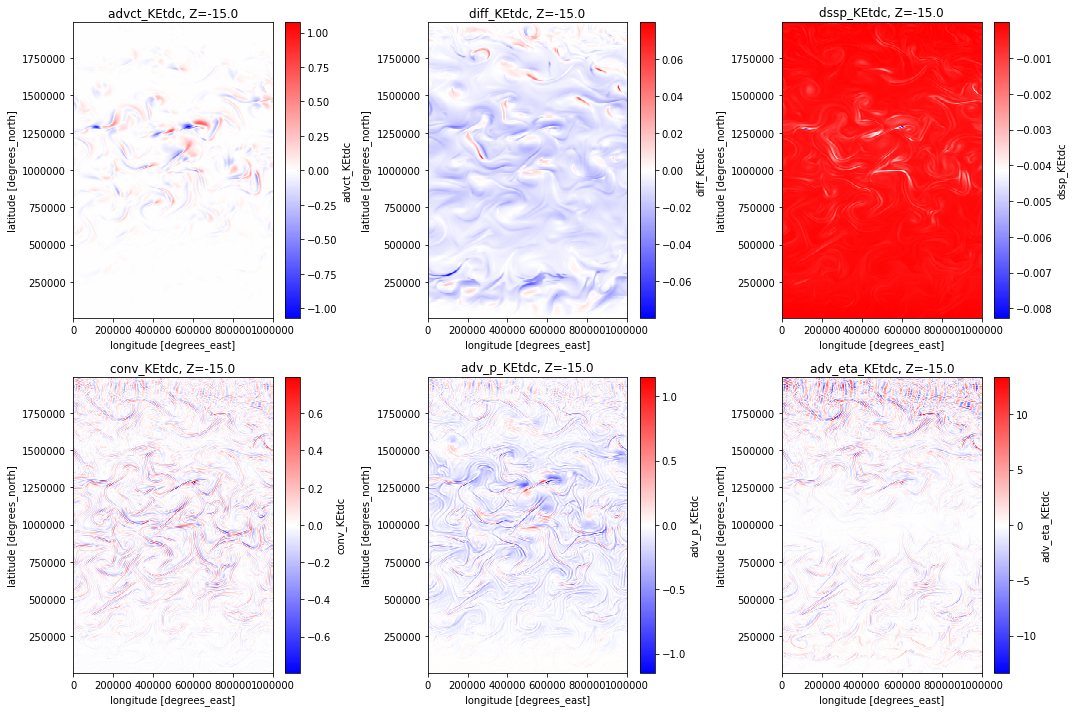

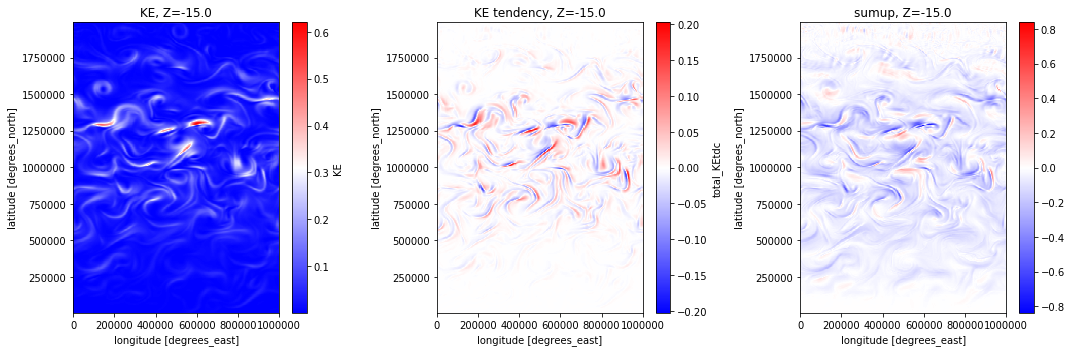

In [7]:
print('start loading data...')

zidx = 1

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axes = axes.ravel()

terms = [re.advct_KEtdc, re.diff_KEtdc,
      re.dssp_KEtdc, re.conv_KEtdc,
      re.adv_p_KEtdc, re.adv_eta_KEtdc]

sumup = (re.advct_KEtdc + re.diff_KEtdc
     + re.dssp_KEtdc + re.conv_KEtdc + re.adv_p_KEtdc)
# +re.adv_eta_KEtdc)

for i, var in enumerate(terms):
    var[3, zidx, 1:-2, :].plot(ax=axes[i], cmap='bwr', add_colorbar=True)
    axes[i].set_title("{0}, Z={1}".format(var.name, dset.Z[zidx].values))

plt.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

dyn.terms.KE[3, zidx, 1:-2, :].plot(ax=axes[0], cmap='bwr', add_colorbar=True)
axes[0].set_title("{0}, Z={1}".format('KE', dset.Z[zidx].values))
dyn.terms.total_KEtdc[3, zidx, 1:-2, :].plot(ax=axes[1], cmap='bwr', add_colorbar=True)
axes[1].set_title("{0}, Z={1}".format('KE tendency', dset.Z[zidx].values))
sumup[3, zidx, 1:-2, :].plot(ax=axes[2], cmap='bwr', add_colorbar=True)
axes[2].set_title("{0}, Z={1}".format('sumup', dset.Z[zidx].values))

plt.tight_layout()


From the above figure, we can see that heat tendency budgets are all closed (exact overlap of **True tendency** and **sum-up tendency**) except in the northern sponge layer where the sponge relaxing effect is not taken into account (no related diagnostics can be output by MITgcm).

#### References
1. <http://pangeo.io/use_cases/physical-oceanography/SOSE.html>
2. <http://mitgcm.org/download/daily_snapshot/MITgcm/doc/Heat_Salt_Budget_MITgcm.pdf>
3. <http://wwwcvs.mitgcm.org/viewvc/MITgcm/MITgcm/doc/diags_changes.txt?view=markup>
4. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2014-November/009586.html>
5. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2014-April/009077.html>
6. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2011-May/007185.html>